In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy

import torch
import seaborn as sns
from pylab import rcParams
from matplotlib import rc
from sklearn.model_selection import train_test_split

from torch import nn, optim
import torch.nn.functional as F
import torch.nn as nn

import warnings
warnings.filterwarnings('ignore')


In [2]:

df = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv',header=None)
df.head().T

,0,1,2,3,4
0,-0.112522,-1.100878,-0.567088,0.490473,0.800232
1,-2.827204,-3.996840,-2.593450,-1.914407,-0.874252
2,-3.773897,-4.285843,-3.874230,-3.616364,-2.384761
3,-4.349751,-4.506579,-4.584095,-4.318823,-3.973292
4,-4.376041,-4.022377,-4.187449,-4.268016,-4.338224
...,...,...,...,...,...
136,0.228077,0.476333,-0.532197,0.990133,0.960304
137,0.123431,0.773820,0.321097,1.086798,0.971020
138,0.925286,1.119621,0.904227,1.403011,1.614392
139,0.193137,-1.436250,-0.421797,-0.383564,1.421456


In [3]:
df.describe()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
count,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,...,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000
mean,-0.262502,-1.649828,-2.492623,-3.119754,-3.167656,-2.866306,-2.272845,-1.797754,-1.409784,-0.935806,...,0.071312,-0.062622,-0.276086,-0.507750,-0.761323,-0.835173,-0.642739,-0.487667,-0.706574,0.584034
std,1.152450,1.445542,1.386457,1.302921,1.104535,0.906312,0.731594,0.622794,0.636863,0.657788,...,1.404425,1.646105,1.894515,2.059366,2.086130,2.056296,1.859409,1.831088,1.414414,0.492937
min,-6.729499,-7.090374,-5.132459,-5.363241,-5.375715,-5.330194,-4.782240,-4.311288,-4.071361,-4.142476,...,-4.167040,-4.557576,-4.530488,-4.563270,-5.150100,-4.880460,-5.496107,-5.880890,-6.092227,0.000000
25%,-1.004220,-2.701936,-3.668585,-4.227337,-4.007630,-3.480666,-2.779832,-2.165808,-1.773870,-1.362003,...,-1.087720,-1.588237,-2.146835,-2.730750,-3.031224,-2.868603,-2.154560,-1.658289,-1.596809,0.000000
50%,-0.297541,-1.661892,-2.586129,-3.388210,-3.469899,-2.947061,-2.285427,-1.750084,-1.422457,-0.910384,...,0.658318,0.717808,0.604747,0.334857,-0.030767,-0.195151,-0.194423,-0.160262,-0.568443,1.000000
75%,0.499909,-0.677998,-1.514187,-2.235690,-2.531153,-2.398797,-1.823480,-1.484107,-1.063592,-0.476477,...,1.169392,1.238651,1.264379,1.234408,1.033957,0.945027,0.951621,1.002628,0.271635,1.000000
max,4.966414,3.479689,2.660597,1.899798,2.147015,1.614375,1.868728,1.804251,1.683730,1.898627,...,3.007606,2.854680,2.912394,2.937685,3.351437,3.432519,3.579448,4.425976,7.402103,1.000000


In [4]:
df.isna().sum()

0      0
1      0
2      0
3      0
4      0
      ..
136    0
137    0
138    0
139    0
140    0
Length: 141, dtype: int64

In [5]:
df.dtypes

0      float64
1      float64
2      float64
3      float64
4      float64
        ...   
136    float64
137    float64
138    float64
139    float64
140    float64
Length: 141, dtype: object

In [6]:
new_columns = list(df.columns)
new_columns[-1] = 'target'
df.columns = new_columns

In [7]:
df.target.value_counts()

target
1.0    2919
0.0    2079
Name: count, dtype: int64

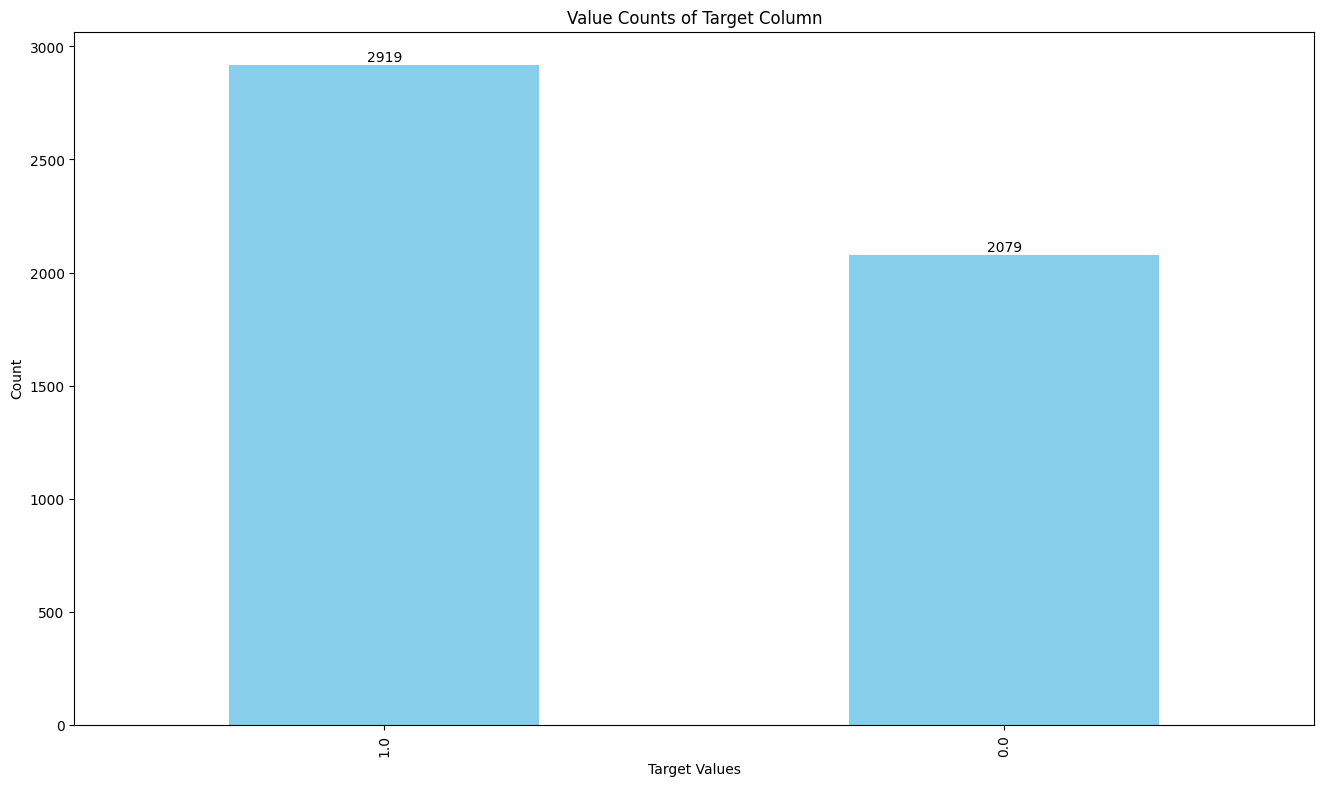

In [8]:
value_counts = df['target'].value_counts()

#plotting
plt.figure(figsize=(16, 9))
value_counts.plot(kind='bar', color='skyblue')
plt.title('Value Counts of Target Column')
plt.xlabel('Target Values')
plt.ylabel('Count')

#Display the count values on top of the bars
for i, count in enumerate(value_counts):
    plt.text(i, count + 0.1, str(count), ha='center', va='bottom')

plt.show()

In [9]:
classes = df.target.unique()

def plot_ecg(data, class_name, ax, n_steps=10):
    #Convert data to a DataFrame
    time_series_df = pd.DataFrame(data)
    #Apply a moving average for smoothing
    smooth_data = time_series_df.rolling(window=n_steps, min_periods=1).mean()
    #Calculate upper and lower bounds for confidence interval
    deviation = time_series_df.rolling(window=n_steps, min_periods=1).std()
    upper_bound = smooth_data + deviation
    lower_bound = smooth_data - deviation
    #Plot the smooth data
    ax.plot(smooth_data, color='black', linewidth=2)
    #plot the confidence interval
    ax.fill_between(time_series_df.index, lower_bound[0], upper_bound[0], color='black', alpha=0.2)
    #set the title
    ax.set_title(class_name)

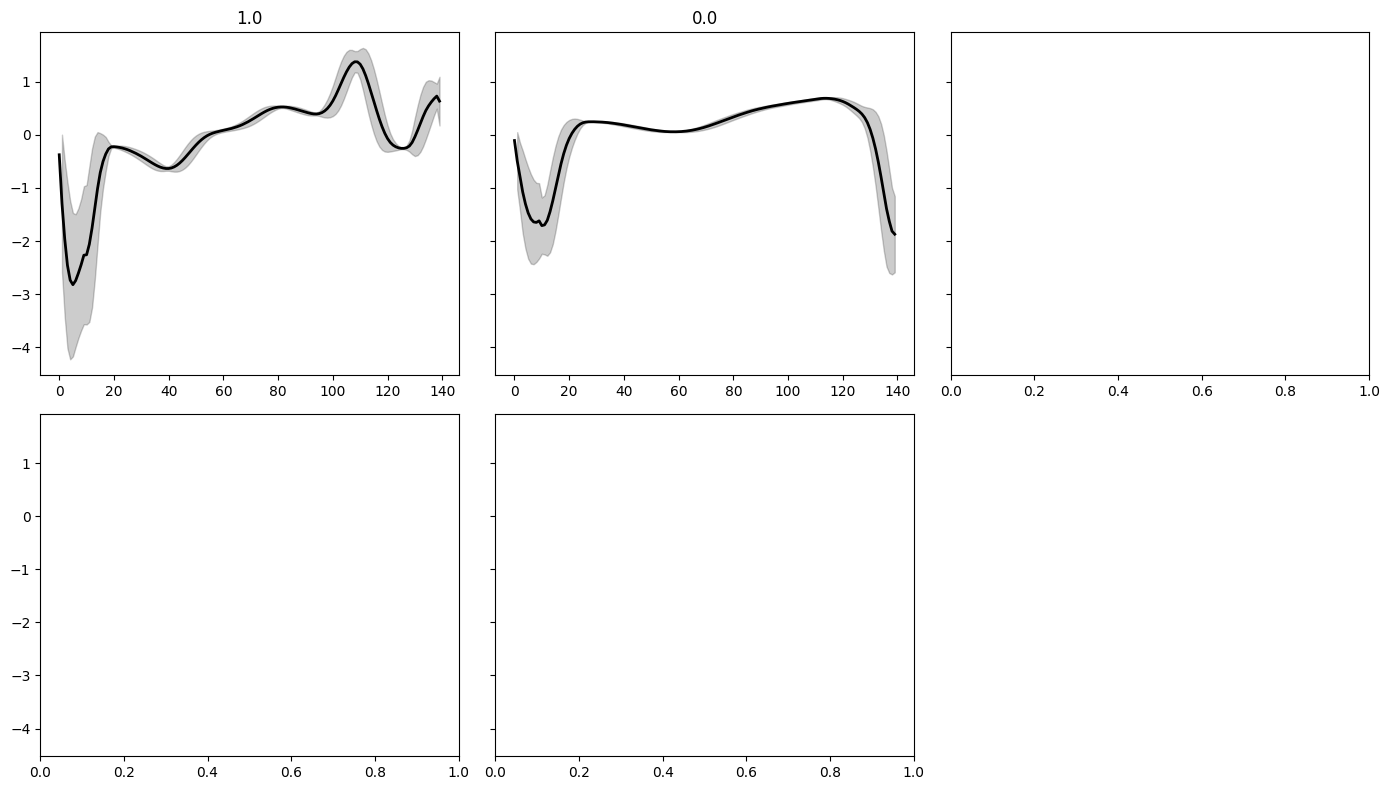

In [10]:
#Plotting setup
fig, axs = plt.subplots(
    nrows=len(classes),
    ncols=3,
    sharey=True,
    figsize=(14, 8)
)

#Plot for each class
for i, cls in enumerate(classes):
    ax = axs.flat[i]
    data = df[df.target == cls].drop(labels='target', axis=1).mean(axis=0).to_numpy()
    plot_ecg(data, cls, ax)

#Adjust Layout and remove extra axes
fig.delaxes(axs.flat[-1])
fig.tight_layout()

plt.show()

In [11]:
normal_df = df[df.target == 1].drop(labels='target', axis=1)
normal_df.shape

(2919, 140)

In [12]:
anomaly_df = df[df.target == 0].drop(labels='target', axis=1)
anomaly_df.shape

(2079, 140)

In [13]:
train_df, val_df = train_test_split(
    normal_df,
    test_size=0.15,
    random_state=42
)

val_df, test_df = train_test_split(
    val_df,
    test_size = 0.30,
    random_state=42
)

In [14]:
def create_dataset(df):
    #Convert dataframe to a list of sequences, each represented as a list of floats
    sequences = df.astype(np.float32).to_numpy().tolist()
    #Convert sequences tp PyTorch tensors, each with shape (sequence_length, 1, num_features)
    dataset = [torch.tensor(s).unsqueeze(1).float() for s in sequences]
    #Extract dimensions of the dataset
    n_seq, seq_len, n_features = torch.stack(dataset).shape
    return dataset, seq_len, n_features

In [15]:
train_dataset, seq_len, n_features = create_dataset(train_df)
val_dataset, _, _ = create_dataset(val_df)
test_normal_dataset, _, _ = create_dataset(test_df)
test_anomaly_dataset, _, _ = create_dataset(anomaly_df)

In [16]:
class Encoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(Encoder, self).__init__()

    self.seq_len, self.n_features = seq_len, n_features
    self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim

    self.rnn1 = nn.LSTM(
      input_size=n_features,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )

    self.rnn2 = nn.LSTM(
      input_size=self.hidden_dim,
      hidden_size=embedding_dim,
      num_layers=1,
      batch_first=True
    )

  def forward(self, x):
    x = x.reshape((1, self.seq_len, self.n_features))

    x, (_, _) = self.rnn1(x)
    x, (hidden_n, _) = self.rnn2(x)

    return hidden_n.reshape((self.n_features, self.embedding_dim))

In [17]:
class Decoder(nn.Module):

  def __init__(self, seq_len, input_dim=64, n_features=1):
    super(Decoder, self).__init__()

    self.seq_len, self.input_dim = seq_len, input_dim
    self.hidden_dim, self.n_features = 2 * input_dim, n_features

    self.rnn1 = nn.LSTM(
      input_size=input_dim,
      hidden_size=input_dim,
      num_layers=1,
      batch_first=True
    )

    self.rnn2 = nn.LSTM(
      input_size=input_dim,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )

    self.output_layer = nn.Linear(self.hidden_dim, n_features)

  def forward(self, x):
    x = x.repeat(self.seq_len, self.n_features)
    x = x.reshape((self.n_features, self.seq_len, self.input_dim))

    x, (hidden_n, cell_n) = self.rnn1(x)
    x, (hidden_n, cell_n) = self.rnn2(x)
    x = x.reshape((self.seq_len, self.hidden_dim))

    return self.output_layer(x)

In [18]:
class Autoencoder(nn.Module):
    def __init__(self,seq_len, n_features, embedding_dim=64):
        super(Autoencoder, self).__init__()

        self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
        self.decoder = Decoder(seq_len, embedding_dim, n_features).to(device)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)

        return x

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Autoencoder(seq_len, n_features, 128)
model = model.to(device)

In [20]:
device

device(type='cpu')

In [21]:
def plot_input_reconstruction(model, dataset, epoch):
    model = model.eval()

    plt.figure(figsize=(10, 5))

    # Take the first sequence from the dataset
    seq_true = dataset[0].to(device)
    seq_pred = model(seq_true)

    with torch.no_grad():
        # Squeeze the sequences to ensure they are 1-dimensional
        input_sequence = seq_true.squeeze().cpu().numpy()
        reconstruction_sequence = seq_pred.squeeze().cpu().numpy()

        # Check the shape after squeezing
        if input_sequence.ndim != 1 or reconstruction_sequence.ndim != 1:
            raise ValueError("Input and reconstruction sequences must be 1-dimensional after squeezing.")

        # Plotting the sequences
        plt.plot(input_sequence, label='Input Sequence', color='black')
        plt.plot(reconstruction_sequence, label='Reconstruction Sequence', color='red')
        plt.fill_between(range(len(input_sequence)), input_sequence, reconstruction_sequence, color='gray', alpha=0.5)

        plt.title(f'Input vs Reconstruction - Epoch {epoch}')
        plt.legend()
        plt.show()


def train_model(model, train_dataset, val_dataset, n_epochs, save_path):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
    criterion = torch.nn.L1Loss(reduction='sum').to(device)
    history = {'train': [], 'val': []}

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')

    for epoch in range(1, n_epochs + 1):
        model.train()

        train_losses = []
        for seq_true in train_dataset:
            optimizer.zero_grad()

            seq_true = seq_true.to(device)
            seq_pred = model(seq_true)

            loss = criterion(seq_pred, seq_true)

            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())

        val_losses = []
        model.eval()
        with torch.no_grad():
            for seq_true in val_dataset:
                seq_true = seq_true.to(device)
                seq_pred = model(seq_true)

                loss = criterion(seq_pred, seq_true)
                val_losses.append(loss.item())

        train_loss = np.mean(train_losses)
        val_loss = np.mean(val_losses)

        history['train'].append(train_loss)
        history['val'].append(val_loss)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            # Save the best model weights
            print("Saving best model")
            torch.save(model.state_dict(), save_path)

        print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')

        if epoch == 1 or epoch % 5 == 0:
            plot_input_reconstruction(model, val_dataset, epoch)

    # Load the best model weights before returning
    model.load_state_dict(best_model_wts)
    return model.eval(), history

Saving best model
Epoch 1: train loss 69.02789183020448 val loss 54.38629026973949


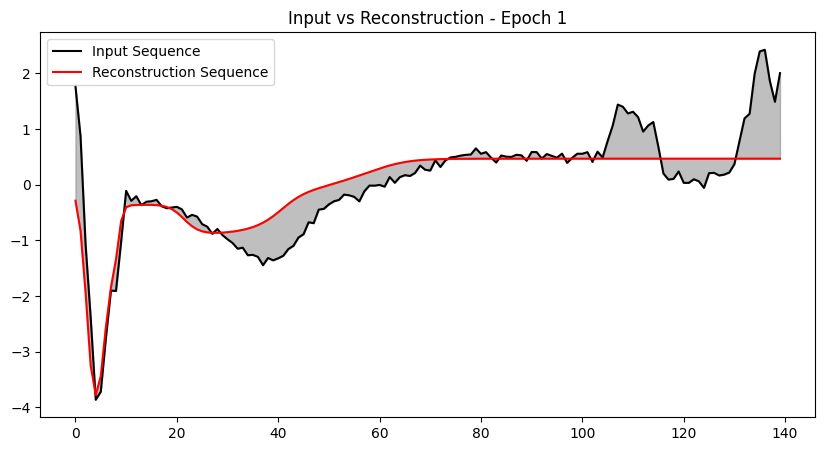

Saving best model
Epoch 2: train loss 51.61175546334761 val loss 49.903793253929784
Saving best model
Epoch 3: train loss 50.19353687681531 val loss 48.732463462679995
Epoch 4: train loss 51.86512442146372 val loss 52.982720842548446
Saving best model
Epoch 5: train loss 50.859902906590825 val loss 48.47474776373969


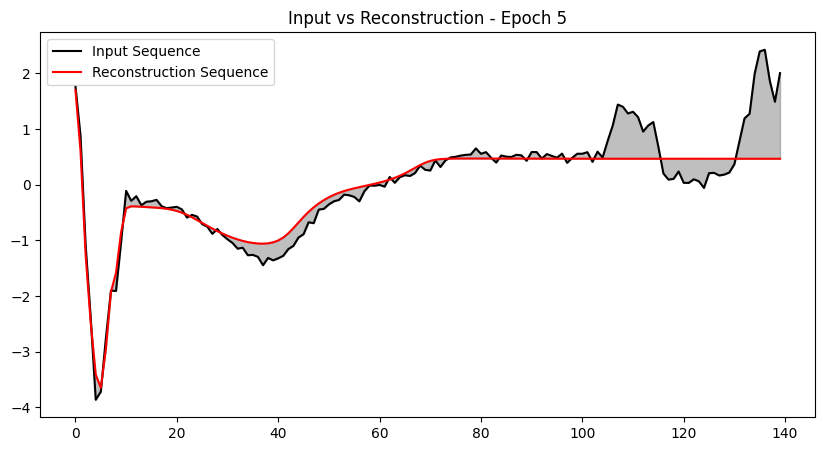

Epoch 6: train loss 52.39106620333455 val loss 53.61060651143392
Epoch 7: train loss 52.09480004500882 val loss 50.413861031625785
Epoch 8: train loss 49.818372262095984 val loss 48.647597930010626
Epoch 9: train loss 47.743380141037214 val loss 49.6926383785173
Saving best model
Epoch 10: train loss 47.42528545697915 val loss 44.71585224500669


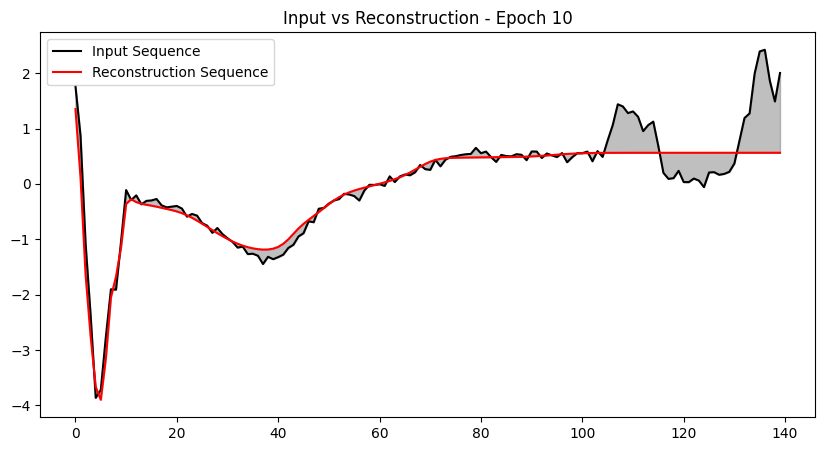

Saving best model
Epoch 11: train loss 45.310622264088664 val loss 38.01991698321174
Saving best model
Epoch 12: train loss 34.25292358452252 val loss 31.32297508389342
Saving best model
Epoch 13: train loss 31.51798440832517 val loss 28.237903037102395
Epoch 14: train loss 30.14674535810539 val loss 29.722500663956787
Saving best model
Epoch 15: train loss 29.412137657728277 val loss 26.538580532946618


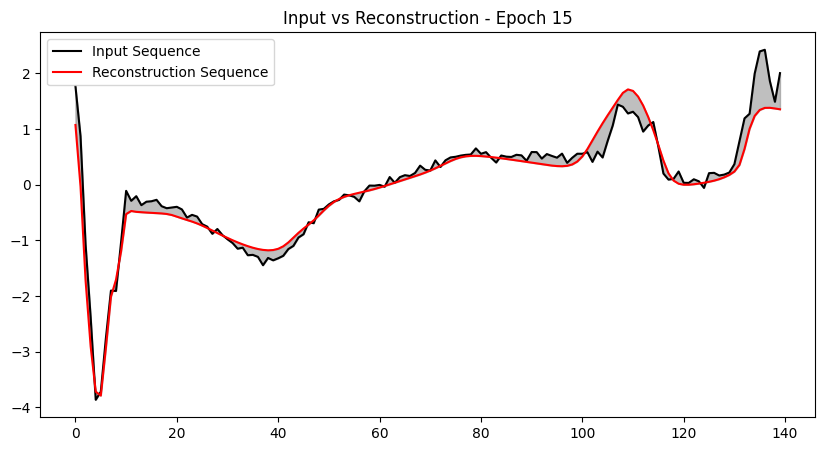

Epoch 16: train loss 28.08373191999553 val loss 31.488880628074696
Saving best model
Epoch 17: train loss 27.01212866120836 val loss 25.845804610283547
Epoch 18: train loss 25.802614987352978 val loss 31.861950394374873
Saving best model
Epoch 19: train loss 25.060310794287563 val loss 23.330878859251932
Saving best model
Epoch 20: train loss 24.322521866641186 val loss 22.191928405387728


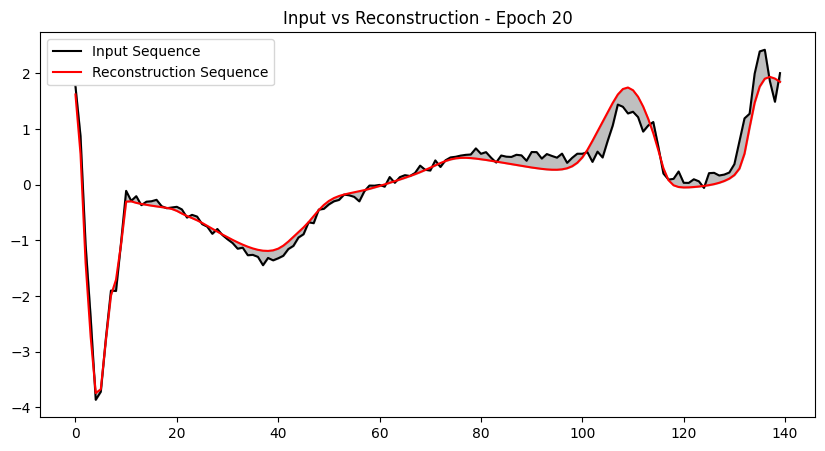

Epoch 21: train loss 23.023985806995224 val loss 25.77738420324388
Saving best model
Epoch 22: train loss 22.098867947225944 val loss 21.07666604970795
Saving best model
Epoch 23: train loss 22.309559504191082 val loss 20.669554654289694
Saving best model
Epoch 24: train loss 21.681468291323014 val loss 19.400147366367914
Epoch 25: train loss 21.366452610334147 val loss 21.277180353800457


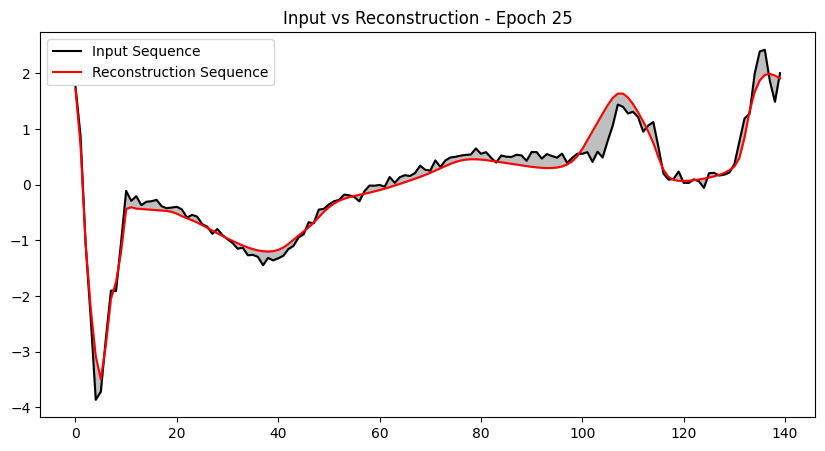

Epoch 26: train loss 20.960859862607798 val loss 19.40346193936915
Epoch 27: train loss 20.533117787100913 val loss 23.994368889752558
Saving best model
Epoch 28: train loss 20.436795769368196 val loss 19.16070657929564
Epoch 29: train loss 20.447601113478918 val loss 19.883696334813934
Epoch 30: train loss 20.08102238173448 val loss 23.281208967071734


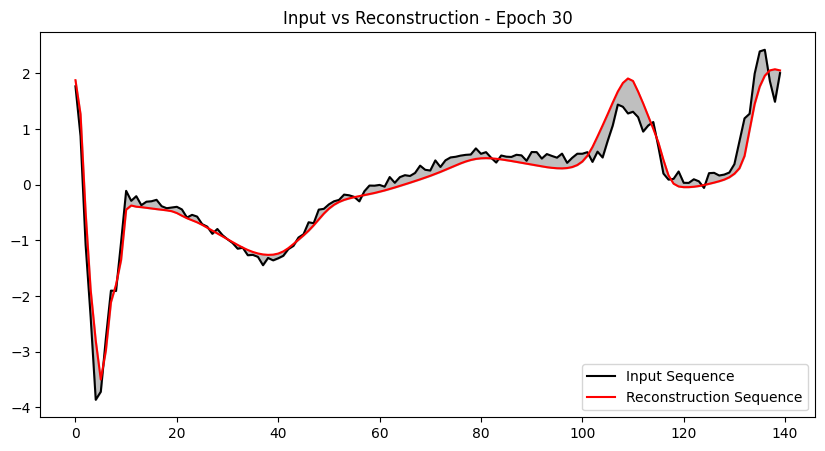

Saving best model
Epoch 31: train loss 19.559270728456067 val loss 18.303202367296407
Epoch 32: train loss 19.356938327141993 val loss 18.386940307866514
Epoch 33: train loss 19.112851217455173 val loss 20.91221600576164
Saving best model
Epoch 34: train loss 18.65112133710339 val loss 18.216020150901446
Saving best model
Epoch 35: train loss 18.679446385686123 val loss 17.301728338977092


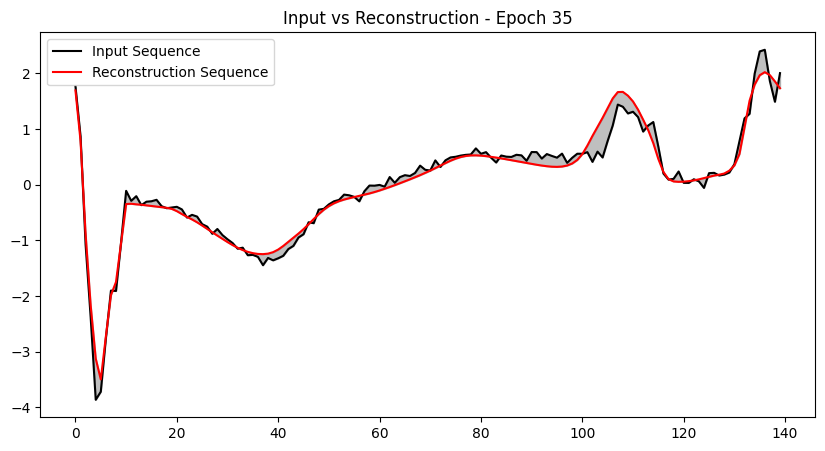

Saving best model
Epoch 36: train loss 18.49612186109765 val loss 17.151846340279175
Epoch 37: train loss 18.47238114801735 val loss 20.053405300464505
Saving best model
Epoch 38: train loss 17.53649835613455 val loss 16.43377721075918
Epoch 39: train loss 17.627374815104805 val loss 16.620211956547756
Saving best model
Epoch 40: train loss 17.296009926486526 val loss 15.908812198763579


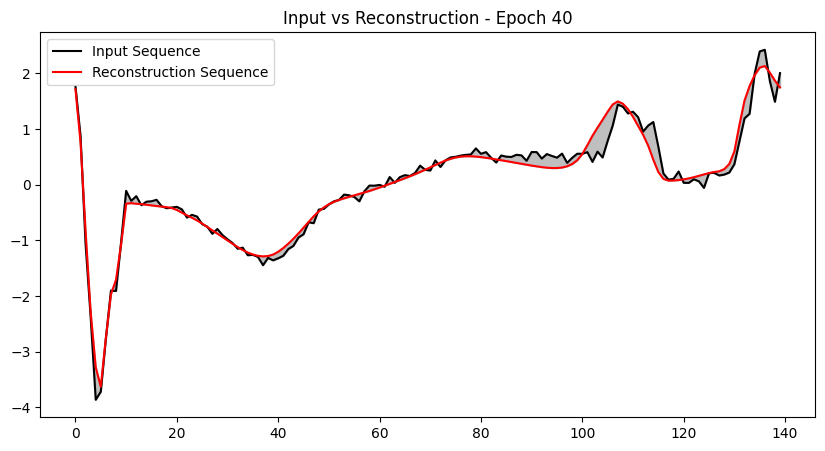

Epoch 41: train loss 16.920575182267804 val loss 16.146258952570896
Saving best model
Epoch 42: train loss 16.709280233333207 val loss 15.291433934292762
Epoch 43: train loss 16.227815329379872 val loss 15.534725778243121
Epoch 44: train loss 16.11934004902407 val loss 18.09949965570487
Epoch 45: train loss 16.20413422824778 val loss 18.656742868859784


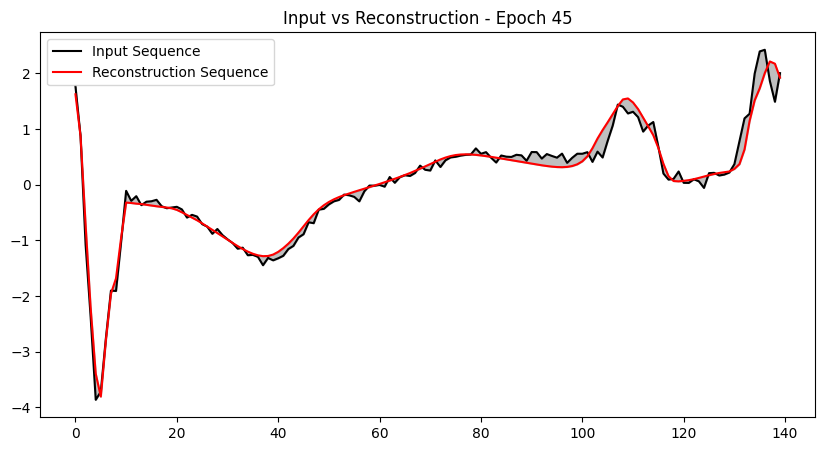

Epoch 46: train loss 16.08826998614919 val loss 18.547718967487608
Epoch 47: train loss 15.853636192343304 val loss 16.46554035922281
Saving best model
Epoch 48: train loss 15.912040871124699 val loss 14.557004747827069
Epoch 49: train loss 15.50877464917916 val loss 15.773048619039697
Epoch 50: train loss 15.31785790125529 val loss 14.654808889027514


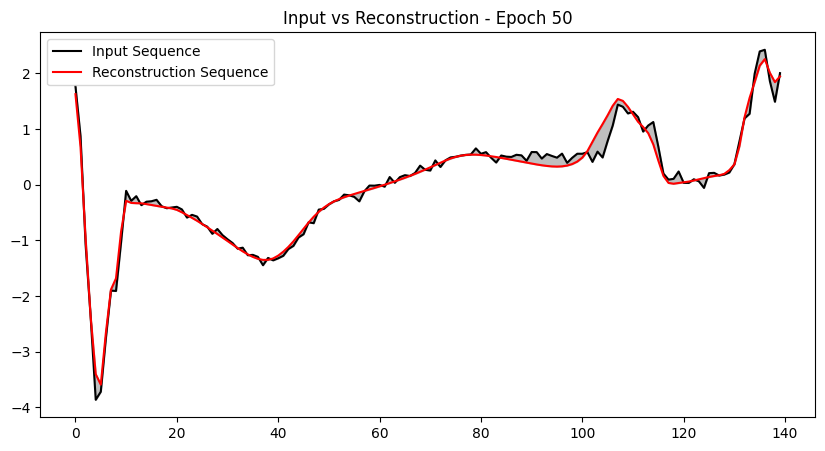

Epoch 51: train loss 15.128693058432134 val loss 15.96203470853419
Epoch 52: train loss 15.018590449325888 val loss 16.15658557492923
Epoch 53: train loss 15.14800398602499 val loss 20.345694794374353
Epoch 54: train loss 14.929868410018988 val loss 15.324842094595915
Epoch 55: train loss 14.992798095458653 val loss 17.419829044466706


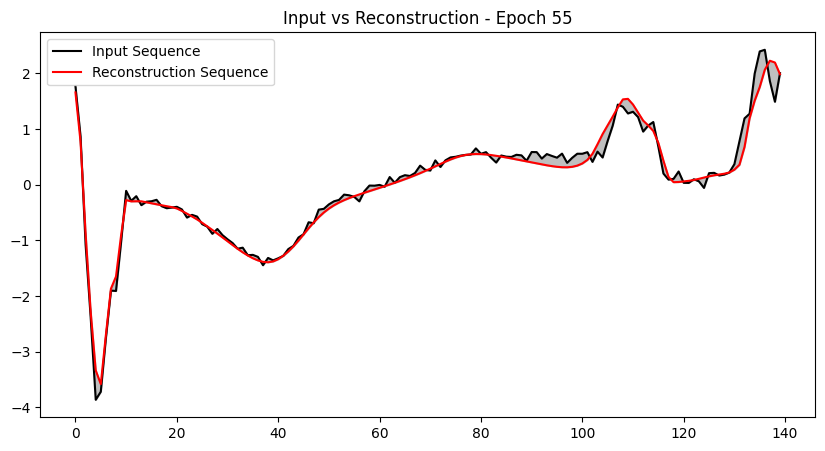

Epoch 56: train loss 14.891994300843823 val loss 17.878641988716872
Epoch 57: train loss 14.705245119869012 val loss 15.803354961420196
Saving best model
Epoch 58: train loss 14.674689238900765 val loss 13.853582545822741
Epoch 59: train loss 14.723681629592976 val loss 14.44586037966161
Epoch 60: train loss 14.549141691077962 val loss 15.049453981561598


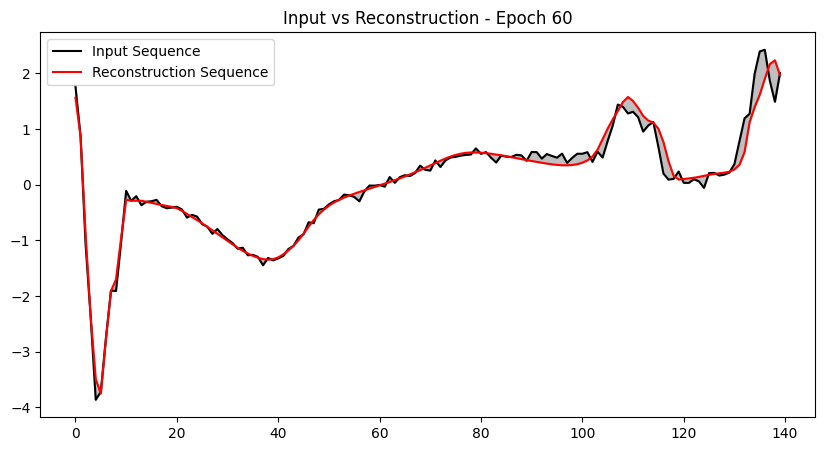

Epoch 61: train loss 14.356468787072215 val loss 14.457411903181887
Epoch 62: train loss 14.254629965801001 val loss 14.563634922301848
Saving best model
Epoch 63: train loss 14.227470514227527 val loss 13.599824562571406
Saving best model
Epoch 64: train loss 14.271912973573832 val loss 13.165222889457652
Epoch 65: train loss 14.18013810169692 val loss 20.140421038359598


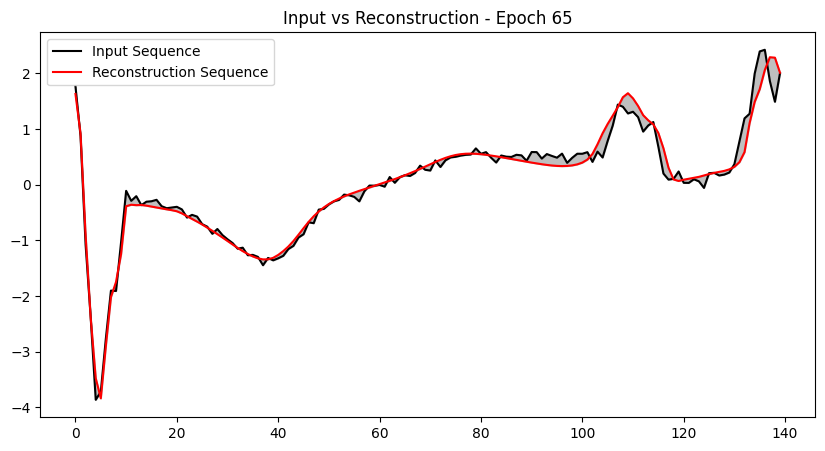

Epoch 66: train loss 13.976799396966937 val loss 13.297412186666252
Epoch 67: train loss 13.975633856078781 val loss 14.882042476554322
Epoch 68: train loss 13.812451708946243 val loss 13.840613598917045
Epoch 69: train loss 14.003477513045373 val loss 14.304125223284453
Epoch 70: train loss 13.62417656718988 val loss 14.322417405695697


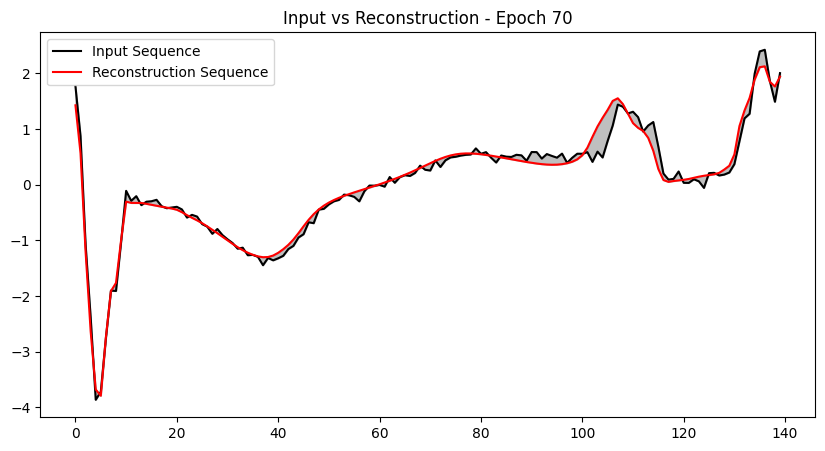

Epoch 71: train loss 13.934416295635465 val loss 14.536402707006417
Epoch 72: train loss 13.856242017657562 val loss 13.235710302988688
Epoch 73: train loss 13.431032802538736 val loss 13.765710399041769
Saving best model
Epoch 74: train loss 13.447672019222003 val loss 12.94411904827442
Epoch 75: train loss 13.515579462916271 val loss 18.485220413582


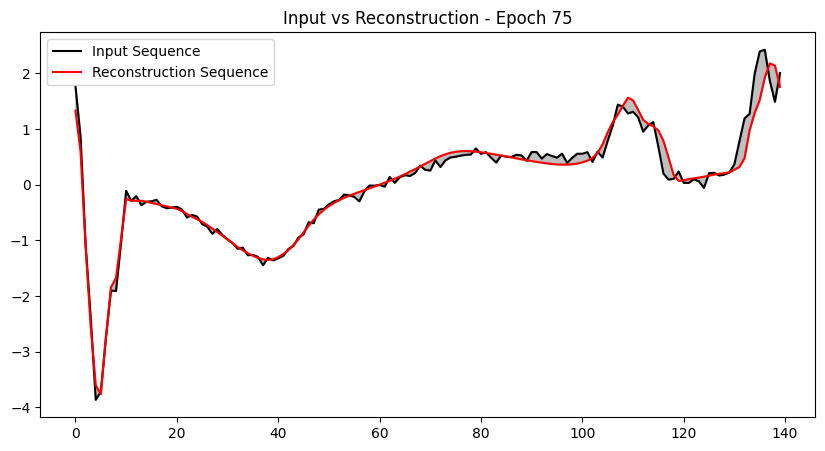

Saving best model
Epoch 76: train loss 13.308562307961282 val loss 12.851587239433737
Epoch 77: train loss 13.366603522087383 val loss 13.282901673535116
Saving best model
Epoch 78: train loss 13.09830135839786 val loss 12.314428460364248
Epoch 79: train loss 13.361131976949068 val loss 12.604297949597726
Epoch 80: train loss 13.146729374739106 val loss 15.324486224479925


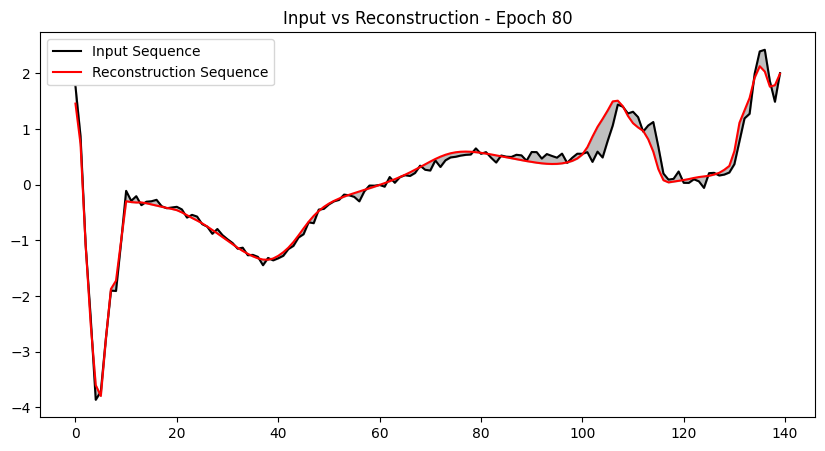

Epoch 81: train loss 13.235662940239436 val loss 15.068236815384012
Epoch 82: train loss 13.390564442641885 val loss 14.673299870459863
Epoch 83: train loss 13.213768147787995 val loss 16.77153869392046
Epoch 84: train loss 13.150636329135795 val loss 13.097310589809045
Epoch 85: train loss 12.68296231612329 val loss 17.9467419300204


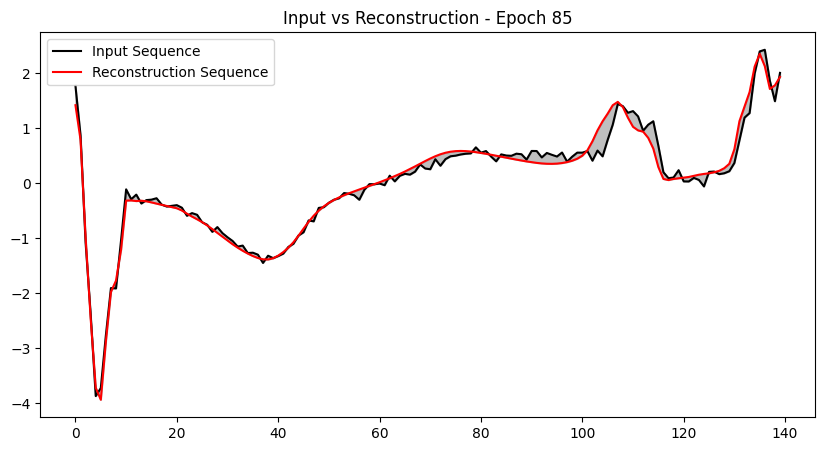

Epoch 86: train loss 12.98482480927467 val loss 12.892125609653448
Epoch 87: train loss 12.80552461425031 val loss 13.611106517268162
Epoch 88: train loss 12.799965824633055 val loss 13.028985261917114
Epoch 89: train loss 12.746702295693117 val loss 13.0992949850419
Epoch 90: train loss 12.703125897168825 val loss 12.839447872311462


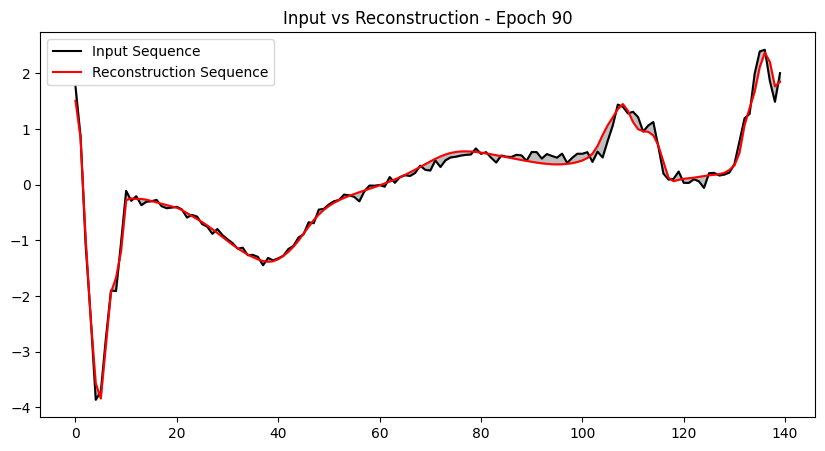

Epoch 91: train loss 12.734258377470349 val loss 13.380428404589884
Epoch 92: train loss 12.851028985719632 val loss 15.137108525419547
Epoch 93: train loss 12.812100824642835 val loss 12.488895040711546
Epoch 94: train loss 12.932298243790564 val loss 12.577006015902251
Epoch 95: train loss 12.555470661692253 val loss 13.176051259819978


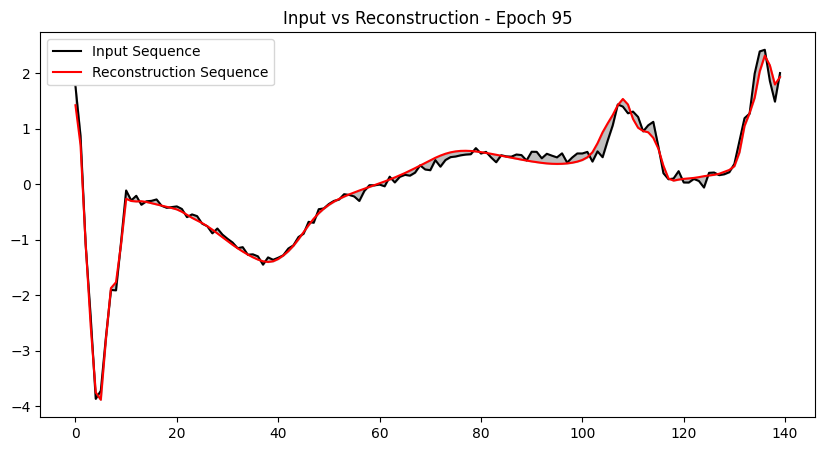

Epoch 96: train loss 12.69304366517288 val loss 13.644890808591656
Saving best model
Epoch 97: train loss 12.556946408887969 val loss 12.207780407924279
Saving best model
Epoch 98: train loss 12.2845382115765 val loss 12.107014978633208
Epoch 99: train loss 12.521627675617284 val loss 12.303237333796382
Epoch 100: train loss 12.369707331643957 val loss 12.452551269842909


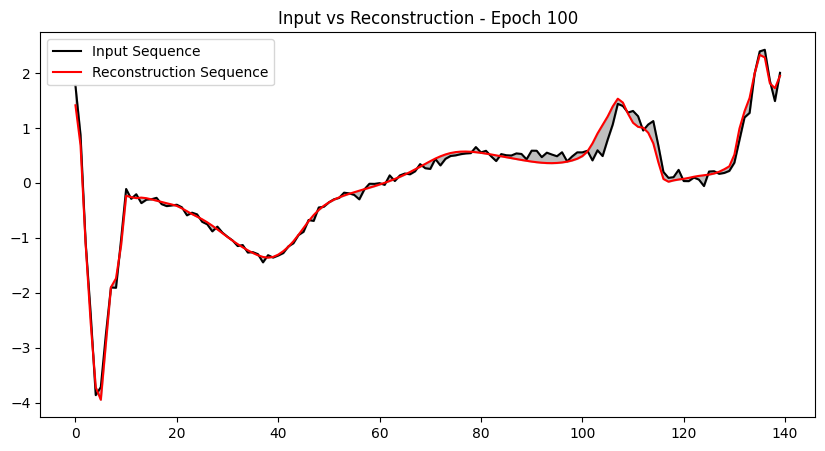

In [22]:
save_path = 'C:\\Users\\aman.gogoriya\\Desktop\\best_model.pth'
model, history = train_model(model, train_dataset, val_dataset, 100, save_path)

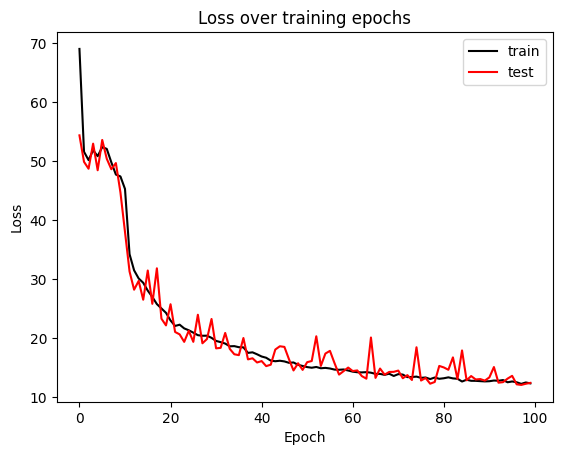

In [23]:
ax = plt.figure().gca()

ax.plot(history['train'],label='Train Loss',color='black')
ax.plot(history['val'],label='Val Loss',color='Red')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss over training epochs')
plt.show();

In [24]:
model = Autoencoder(seq_len, n_features, 128)

model.load_state_dict(torch.load('C:\\Users\\aman.gogoriya\\Desktop\\best_model.pth'))

model = model.to(device)
model.eval()

Autoencoder(
  (encoder): Encoder(
    (rnn1): LSTM(1, 256, batch_first=True)
    (rnn2): LSTM(256, 128, batch_first=True)
  )
  (decoder): Decoder(
    (rnn1): LSTM(128, 128, batch_first=True)
    (rnn2): LSTM(128, 256, batch_first=True)
    (output_layer): Linear(in_features=256, out_features=1, bias=True)
  )
)

In [25]:
def predict(model, dataset):
  predictions, losses = [], []
  criterion = nn.L1Loss(reduction='sum').to(device)
  with torch.no_grad():
    model = model.eval()
    for seq_true in dataset:
      seq_true = seq_true.to(device)
      seq_pred = model(seq_true)

      loss = criterion(seq_pred, seq_true)

      predictions.append(seq_pred.cpu().numpy().flatten())
      losses.append(loss.item())
  return predictions, losses

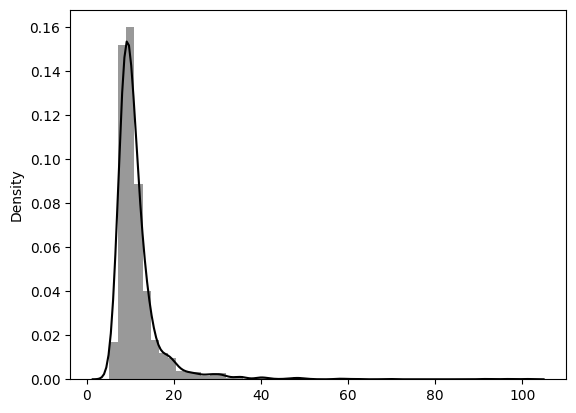

In [26]:
_, losses = predict(model, train_dataset)

sns.distplot(losses, bins=50, kde=True, label='Train',color='black');

#Visualising train loss

In [27]:
Threshold = 25

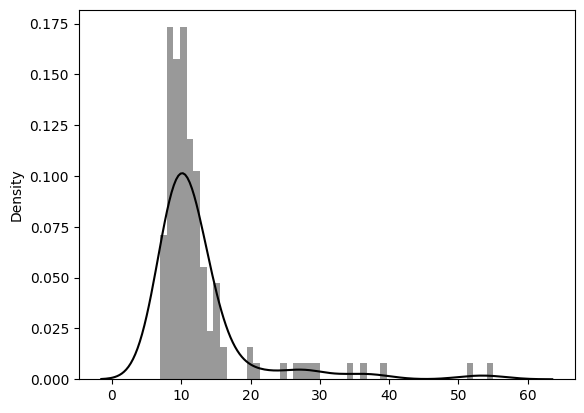

In [28]:
predictions, pred_losses = predict(model, test_normal_dataset)
sns.distplot(pred_losses, bins=50, kde=True,color='black');

In [29]:
correct = sum(l <= 25 for l in pred_losses)
print(f'Correct normal predictions: {correct}/{len(test_normal_dataset)}')

Correct normal predictions: 123/132


In [30]:

anomaly_dataset = test_anomaly_dataset[:len(test_normal_dataset)]


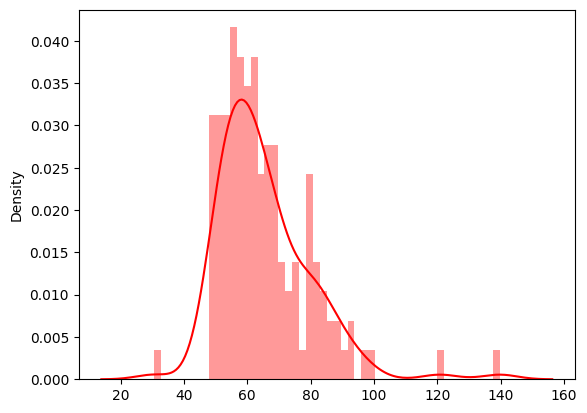

In [31]:
predictions, pred_losses = predict(model, anomaly_dataset)
sns.distplot(pred_losses, bins=50, kde=True,color='red');

In [32]:

correct = sum(l > 25 for l in pred_losses)
print(f'Correct anomaly predictions: {correct}/{len(anomaly_dataset)}')

Correct anomaly predictions: 132/132


In [33]:
def plot_prediction(data, model, title, ax):
  predictions, pred_losses = predict(model, [data])

  ax.plot(data, label='true',color='black')
  ax.plot(predictions[0], label='reconstructed',color='red')
  ax.set_title(f'{title} (loss: {np.around(pred_losses[0], 2)})')
  ax.legend()

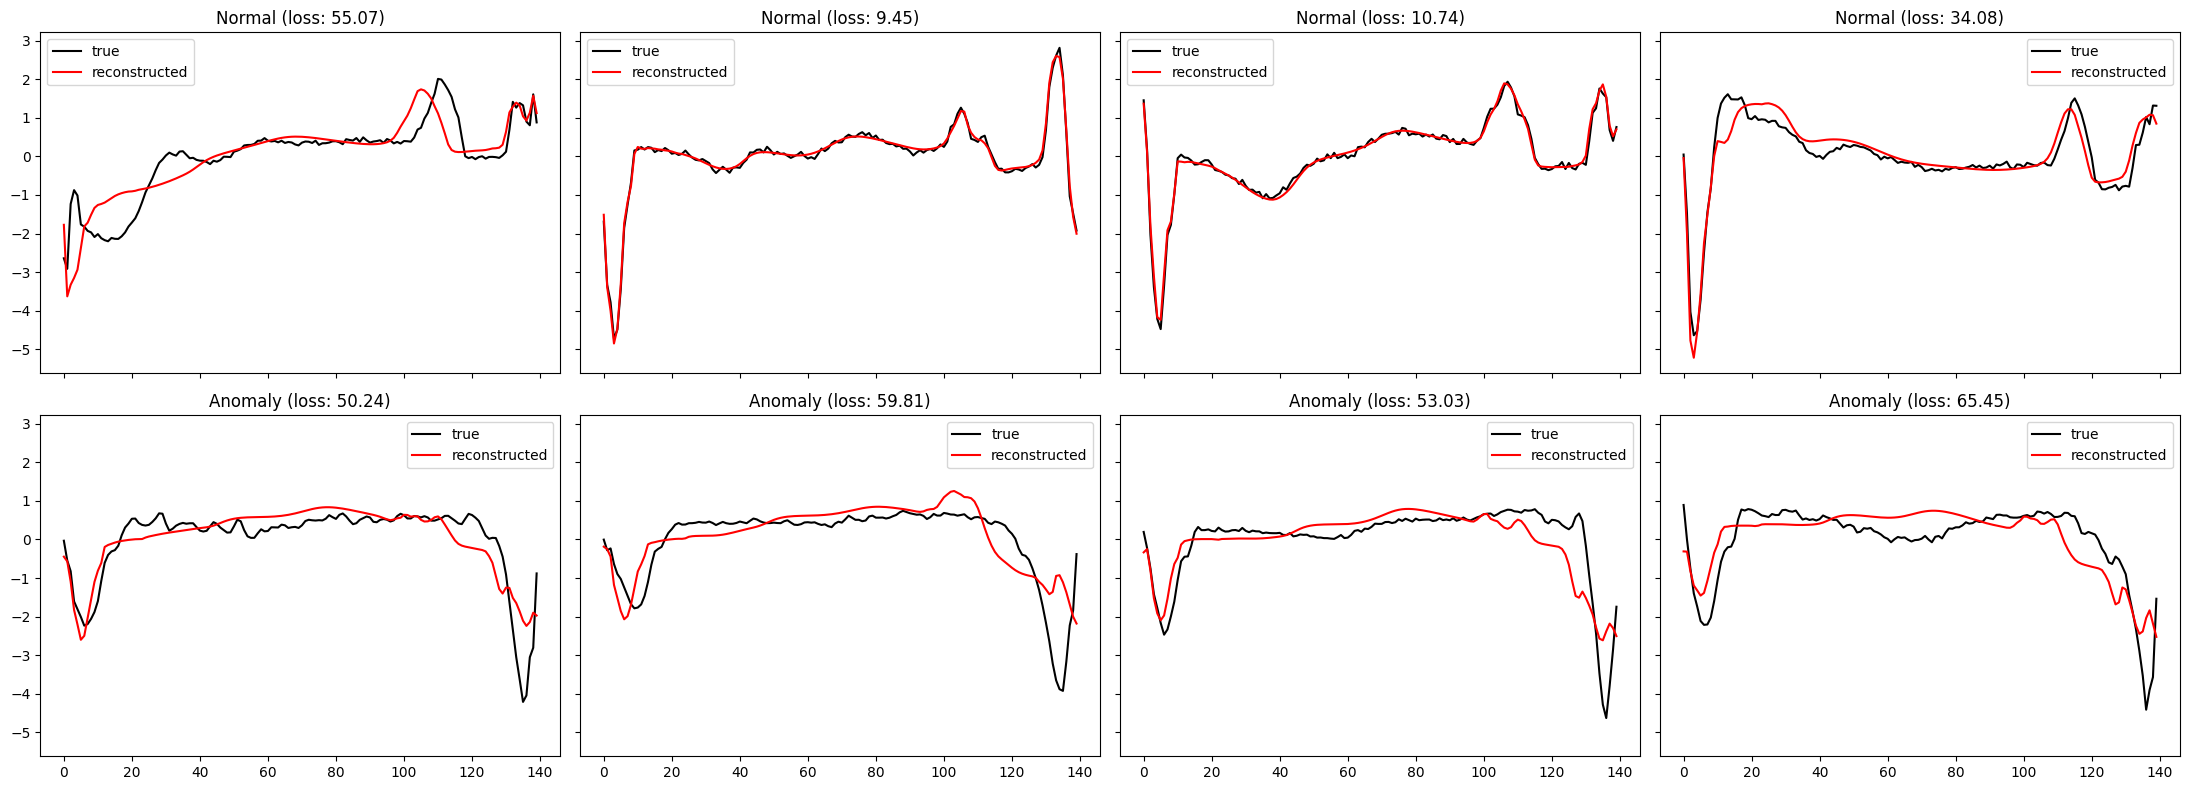

In [34]:
fig, axs = plt.subplots(
  nrows=2,
  ncols=4,
  sharey=True,
  sharex=True,
  figsize=(22, 8)
)

for i, data in enumerate(test_normal_dataset[:4]):
  plot_prediction(data, model, title='Normal', ax=axs[0, i])

for i, data in enumerate(test_anomaly_dataset[:4]):
  plot_prediction(data, model, title='Anomaly', ax=axs[1, i])

fig.tight_layout();